# Определение тональности комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нам нужно создать модель, которая будет классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Цель: построить модель со значением метрики качества *F1* не меньше 0.75. 


Основными этапами нашего проекта станут:

* Загрузка и подготовка данных
* Обучение разных моделей
* Оценка метрики качества F1 моделей
* Выбор лучшей модели, её тестирование, проверка модели на вменяемость 
  
Проект выполнен в **Jupyter Notebook**, версия сервера блокнотов: 6.1.4. Версия **Python** 3.7.8.
В проекте использованы:
* **re**
* **Pandas**
* **NumPy** 
* **scikit-learn**
* **MatPlotLib**
* **Spacy**
* **NLTK**
* **IPython**

## Подготовка

In [1]:
# Импортируем необходимые библиотеки.
import re

import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
import spacy
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
# Загрузим и взглянем на датасет.
data = pd.read_csv('/datasets/toxic_comments.csv')
display(data)
# Изучим основную информацию.
print(data.info())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


In [3]:
# Проверим датасет на наличие полных дубликатов.
print('Количество полных дубликатов в датасете:', 
      data.duplicated().sum())

Количество полных дубликатов в датасете: 0


In [4]:
%%time
# Лемматизируем тексты.
nlp = spacy.load("en_core_web_sm")
data['lemmatized'] = data['text'].apply(
    lambda x: ' '.join(
        [y.lemma_ for y in nlp(x)]
    )
)

CPU times: user 52min 33s, sys: 11.9 s, total: 52min 45s
Wall time: 53min 3s


In [5]:
# Избавимся от служебного слова -PRON- библиотеки Spacy.
data['lemmatized'] = data['lemmatized'].str.replace('-PRON-', '')
# Удалим лишние символы при помощи регулярных выражений.
data['lemmatized'] = data['lemmatized'].apply(
    lambda x: re.sub(
        r'[^a-zA-Z ]', ' ', x
    )
)
# Избавимся от лишних пробелов.
data['lemmatized'] = data['lemmatized'].apply(
    lambda x: ' '.join(
        x.split()
    )
)

In [6]:
# Взглянем на датасет после наших преобразований.
display(data)

,text,toxic,lemmatized
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under username H...
1,D'aww! He matches this background colour I'm s...,0,d aww match this background colour be seemingl...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man be really not try to edit war be just ...
3,"""\nMore\nI can't make any real suggestions on ...",0,More can not make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,sir be hero any chance remember what page that...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,and for the second time of asking when view co...
159567,You should be ashamed of yourself \n\nThat is ...,0,should be ashamed of that be a horrible thing ...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer umm there s no actual article for pros...
159569,And it looks like it was actually you who put ...,0,and look like be actually who put on the speed...


In [7]:
# Тексты обработаны. 
# Выделим целевой признак.
features = data['lemmatized']
target = data['toxic']
# Разобьем датасет на тренировочную и тестовую выборки.
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size=.2, 
    random_state=12345,
    stratify=target
)
# Выборки готовы. Взглянем на их размеры. 
# Изначальный набор данных имел 159571 объект.
sets = [features_train, features_test, target_train, target_test]
set_names = ['features_train', 'features_test', 
             'target_train', 'target_test']
for name, kit in zip(set_names, sets):
    print('Размер выборки', name, 'составляет', kit.shape)

Размер выборки features_train составляет (127656,)
Размер выборки features_test составляет (31915,)
Размер выборки target_train составляет (127656,)
Размер выборки target_test составляет (31915,)


Text(0.5, 1.0, 'Соотношение классов в тренировочной выборке')

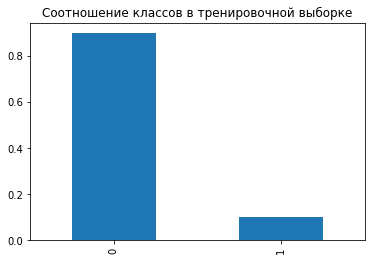

In [8]:
# Оценим соотношение классов в тренировочной выборке.
target_train.value_counts(normalize=True).plot(kind='bar')
plt.title('Соотношение классов в тренировочной выборке')

In [9]:
# Изменим формат тренировочного и тестового наборов признаков.
corpus_train = features_train.values
corpus_test = features_test.values

In [10]:
# Загрузим английские стоп-слова.
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
# Создадим счётчик величин TF-IDF.
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Выучим словарь и создадим TF-IDF матрицу тренировочной выборки.
features_train_vec = count_tf_idf.fit_transform(corpus_train)
# Создадим TF-IDF матрицу тестовой выборки.
features_test_vec = count_tf_idf.transform(corpus_test)
# Проверим размеры наборов.
print('Размер набора features_train_vec составляет', features_train_vec.shape)
print('Размер набора features_test_vec составляет', features_test_vec.shape)

Размер набора features_train_vec составляет (127656, 138031)
Размер набора features_test_vec составляет (31915, 138031)


### Вывод

На этапе подготовки нами было сделано следующее:  
1. Импортированы необходимые для выполнения проекта библиотеки.  
2. Загружен и изучен датасет. Проверен на полные дубликаты.  
3. Тексты лемматизированы. После лемматизации проведена очистка текстов от ненужных символов.  
4. Датасет разбит на тренировочную (80 %) и тестовую (20 %) выборки.  
5. Проведена оценка соотношения классов в тренировочной выборке. Нетоксичных комментариеви значительно больше, чем токсичных — почти 90 % к 10 %. Принято решение придать больший вес классу 1 (токсичные комментарии) для достижения сбалансированности.
6. Был создан счетчик величин TF-IDF. Получены TF-IDF-матрицы тренировочной и тестовой выборок. Получены ожидаемые размеры выборок.  

Перейдем к обучению моделей. Мы обучим 2 модели, выберем лучшую по показателю метрики F1. Затем проверим на вменяемость.

## Обучение

### Логистическая регрессия

In [12]:
# Подберем гиперпараметры модели, используя pipeline.
pipe_lr = Pipeline([
                ('clf', LogisticRegression(
                    random_state=12345, 
                    class_weight='balanced', 
                    solver='liblinear'))])

grid_params_lr = [
    {'clf__penalty': ['l1', 'l2'],
     'clf__C': [1.0, 0.5]}
] 

grid_cv_lr = GridSearchCV(estimator=pipe_lr,
                          param_grid=grid_params_lr,
                          scoring='f1',
                          cv=10, 
                          n_jobs=-1)

grid_cv_lr.fit(features_train_vec, target_train)
# Выявим лучшие параметры.
best_parameters = grid_cv_lr.best_params_
print('Лучшие значения гиперпараметров:\n', best_parameters)
# Выявим лучшее значение F1-меры.
best_cv_lr_score = grid_cv_lr.best_score_
print('Лучшая F1-мера модели логистической регрессии', best_cv_lr_score)

Лучшие значения гиперпараметров:
 {'clf__C': 1.0, 'clf__penalty': 'l1'}
Лучшая F1-мера модели логистической регрессии 0.7517491937322238


In [14]:
# Применим модель с лучшими гиперпараметрами.
model_lr = LogisticRegression(random_state=12345, 
                              class_weight='balanced', 
                              solver='liblinear',
                              penalty='l1', 
                              C=1.0)
model_lr.fit(features_train_vec, target_train)
predicted_lr = model_lr.predict(features_test_vec)
print('F1-мера модели логистической регрессии составляет', f1_score(target_test, predicted_lr))
lr_score = f1_score(target_test, predicted_lr)

F1-мера модели логистической регрессии составляет 0.7656909462219197


### Дерево решений

In [21]:
# Подберем гиперпараметры модели, используя pipeline.
pipe_dt = Pipeline([
                ('model', DecisionTreeClassifier(
                    random_state=12345, 
                    class_weight='balanced'))])

grid_params_dt = [
    {'model__max_depth': [4, 8, 12],
     'model__min_samples_split': [2, 5, 10],
     'model__min_samples_leaf': [1, 2, 4]}
]

grid_cv_dt = GridSearchCV(estimator=pipe_dt,
                          param_grid=grid_params_dt,
                          scoring='f1',
                          cv=10, 
                          n_jobs=-1)

grid_cv_dt.fit(features_train_vec, target_train)
# Выявим лучшие параметры.
best_parameters = grid_cv_dt.best_params_
print('Лучшие значения гиперпараметров:\n', best_parameters)
# Выявим лучшее значение F1-меры.
best_cv_dt_score = grid_cv_dt.best_score_
print('Лучшая F1-мера модели дерева решений', best_cv_dt_score)

Лучшие значения гиперпараметров:
 {'model__max_depth': 12, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}
Лучшая F1-мера модели дерева решений 0.5949356924707409


In [25]:
# Создадим модель дерева решений.
model_dt = DecisionTreeClassifier(
    random_state=12345, 
    class_weight='balanced',
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=4
)
model_dt.fit(features_train_vec, target_train)
predicted_dt = model_dt.predict(features_test_vec)
print('F1-мера модели дерева решений составляет', f1_score(target_test, predicted_dt))
dt_score = f1_score(target_test, predicted_dt)

F1-мера модели дерева решений составляет 0.5950577919489837


### Вывод

Изначально планировалось создать и протестировать 4 модели:  
* Логистической регрессии
* Градиентного бустинга библиотеки Light GBM
* Дерева решений
* Случайного леса  
  
К сожалению, раз за разом при попытке обучить модели градиентного бустинга и случайного леса ядро Jupyter Notebook умирало. Были предприняты попытки упрощения кода (в целях освобождения оперативной памяти), исключения разных моделей из процесса выполнения проекта. Тем не менее по какой-то причине ядро умирало, если хотя бы одна из этих моделей была задействована в проекте. Было принято решение оставить только модели логистической регрессии и дерева решений.  

Для балансировки классов мы воспользовались параметром class_weight в моделях, указав значение 'balanced'. 
  
Модель логистической регрессии позволила нам добиться поставленной задачи. Достигнутая F1-мера больше 0,75.  
Проверим модель на вменяемость.

## Выводы

In [26]:
# Проверим модель на вменяемость.
dummy = DummyClassifier(random_state=12345, strategy='constant', constant=1)
dummy.fit(features_train_vec, target_train)
predicted_dummy = dummy.predict(features_test_vec)
print('F1-мера дамми-модели составляет', f1_score(target_test, predicted_dummy))
if f1_score(target_test, predicted_dummy) < lr_score:
    print('Выбранная модель вменяема')
else:
    print('Модель невменяема, требуется доработка')

F1-мера дамми-модели составляет 0.18458475540386804
Выбранная модель вменяема


По ходу проекта мы загрузили данные, изучили их. Была проведена обработка текста. Процесс лемматизации текста оказался самым трудоёмким для процессора компьютера. Около часа.  
Затем мы подготовили данные к обучению моделей. Векторизовали признаки. Определили дисбаланс классов.  
Изначально планировалось протестировать 4 модели, но ввиду технических проблем, использовались только две модели.  
Модель логистической регрессии показала значение F1-меры равное 0,766, что говорит нам о выполнении поставленной задачи. Данная модель прошла проверку на вменяемость.